# COVID-19 Logistic Model

The logistic model has an equation:

$$
\frac{dC}{dt} = rC\bigg(1 - \frac{C}{K}\bigg)
$$

Where $C$ is an accumulated number of cases, $r > 0$ is the infection rate, and $K > 0$ is the final epidemic size. The solution of this equation is:

$$
C = \frac{K}{1 + Ae^{-rt}}
$$

Where: $A = \frac{K - C_0}{C_0}$ and $C_0$ is the initial number of cases at time zero.

When I'm trying to understand a model, I find it useful to plot a few versions of the model with different parameters to find out how it behaves. 

[Text(0, 0.5, 'Cases'), Text(0.5, 0, 'Days since...')]

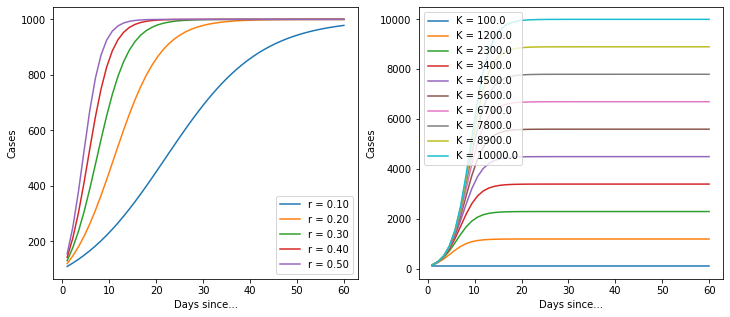

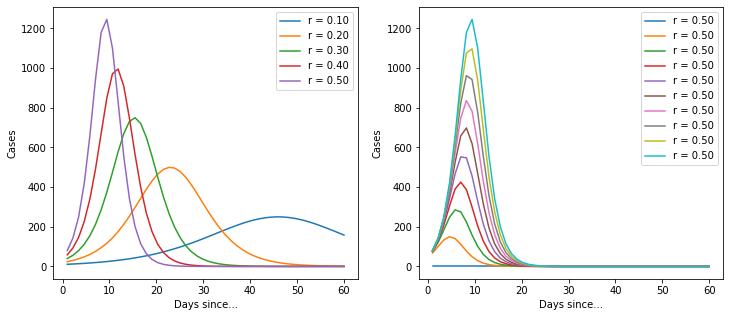

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def C(K, r, t, C_0):
  A = (K-C_0)/C_0
  return K / (1 + A * np.exp(-r * t))

def d_C(K, r, t, C_0):
  c = C(K, r, t, C_0)
  return r * c * (1 - c / K)

r = 0.2
K = 1000
C_0 = 100

t = np.linspace(1,60)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for r in np.linspace(0.1, 0.5, 5):
  ax[0].plot(t, C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[0].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Cases")
for K in np.linspace(100, 10000, 10):
  ax[1].plot(t, C(K, r, t, C_0), label=f"K = {K:0.1f}")
ax[1].legend(loc="best")
ax[1].set(xlabel="Days since...", ylabel="Cases")

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for r in np.linspace(0.1, 0.5, 5):
  ax[0].plot(t, d_C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[0].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Cases")
for K in np.linspace(100, 10000, 10):
  ax[1].plot(t, d_C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[1].legend(loc="best")
ax[1].set(xlabel="Days since...", ylabel="Cases")

Ok, so it's a basic logistic function. But it's quite useful because it implicitly provides an estimate for the total number of cases. Let's import the data again and build a model.

In [0]:
!pip install arviz pymc3==3.8
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import theano

# Load data
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/", parse_dates=["dateRep"], infer_datetime_format=True, dayfirst=True)
df = df.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country'}) # Sane column names
df = df.drop(["day", "month", "year", "geoId"], axis=1) # Not required

country = "China"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2018"] for key in df["country"].unique()}

     |████████████████████████████████| 1.5MB 4.9MB/s 
     |████████████████████████████████| 911kB 29.2MB/s 
     |████████████████████████████████| 4.1MB 44.2MB/s 
     |████████████████████████████████| 337kB 49.4MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


## Logistic Model

In [0]:
def model_factory(country: str, x: np.ndarray, y: np.ndarray):
  with pm.Model() as model:
    t = pm.Data(country + "x_data", x)
    confirmed_cases = pm.Data(country + "y_data", y)

    # Intercept - We fixed this at 100.
    C_0 = pm.Normal("C_0", mu=100, sigma=10)

    # Growth rate: 0.2 is approx value reported by others
    r = pm.Normal("r", mu=0.2, sigma=0.5)

    # Total number of cases. Depends on the population, more people, more infections.
    # It also depends on the total number of people infected.
    # Start with a prior based upon a guess of the initial population, very weak
    proportion_infected = 5e-05 # This value comes from the rough projection that 80000 will be infected in China
    p = populations[country]
    K = pm.Normal("K", mu=p * proportion_infected, sigma=p*0.1)

    # Logistic regression
    growth = C(K, r, t, C_0)

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal(country, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
  return model

## Model Testing

Let's train it on some synthetic data to begin with to make sure the model can actually fit it. Someone more experienced wouldn't need to do this!

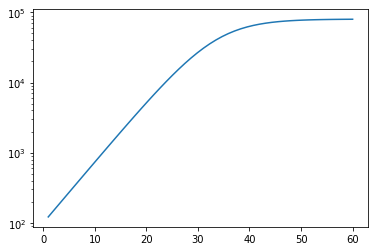

In [0]:
r = 0.2
K = 80000 # This should look something a bit like China
C_0 = 100
t = np.linspace(1,60)
y_synthetic = C(K, r, t, C_0)
plt.plot(t, y_synthetic)
plt.gca().set_yscale("log")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, K, r, C_0]
Sampling chain 1, 50 divergences: 100%|██████████| 1000/1000 [00:07<00:00, 129.60it/s]
There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.05712933545888883, but should be close to 0.8. Try to increase the number of tuning steps.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14463712435528353, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:11<00:00, 89.43it/s]


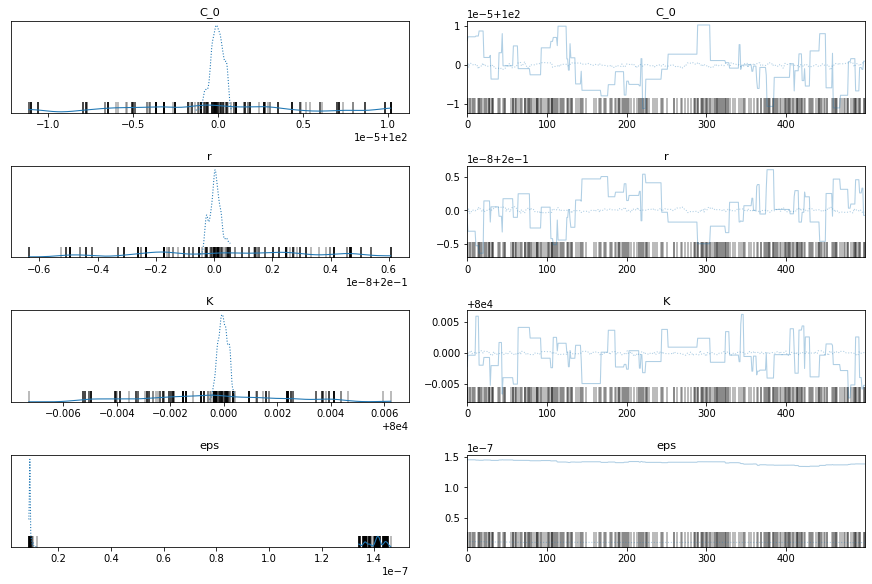

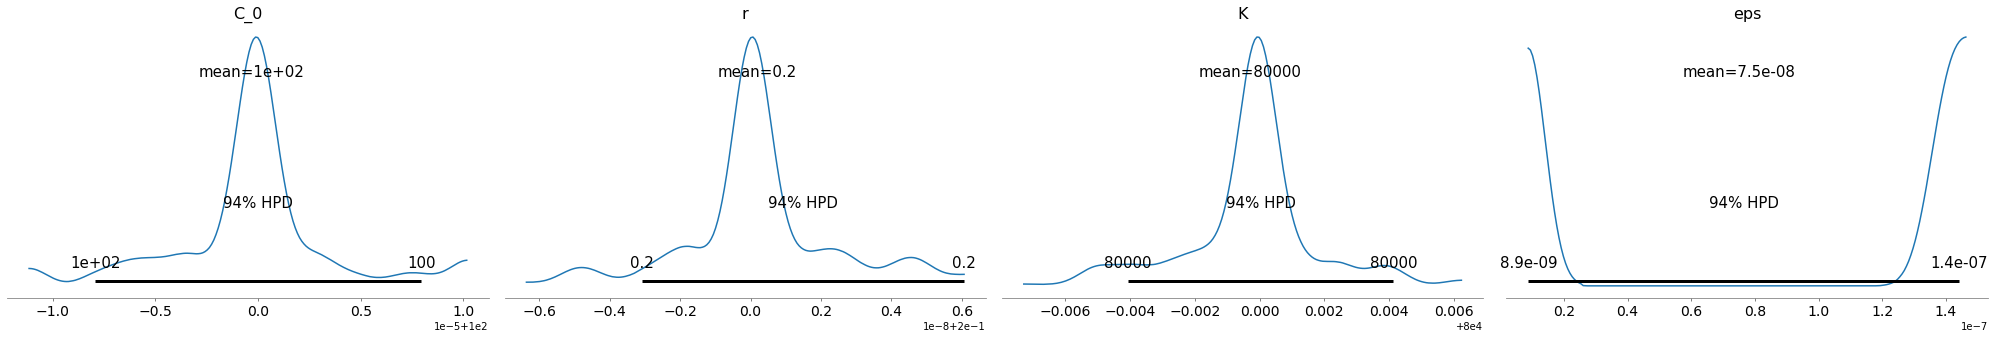

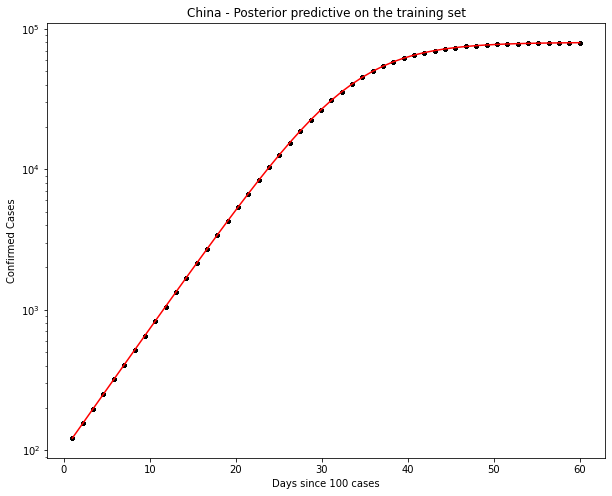

In [0]:
# Training
with model_factory(country, t, y_synthetic) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(t, ppc[country].T, ".k", alpha=0.05)
    ax.plot(t, y_synthetic, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Days since 100 cases", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

## China Data

Ok, the above seems to work ok. The K parameter is quite important here. There are a distinct lack of confirmed cases relative to the population.

Let's give it a whirl on real data.

In [0]:
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, K, r, C_0]
100%|██████████| 1000/1000 [00:09<00:00, 103.27it/s]


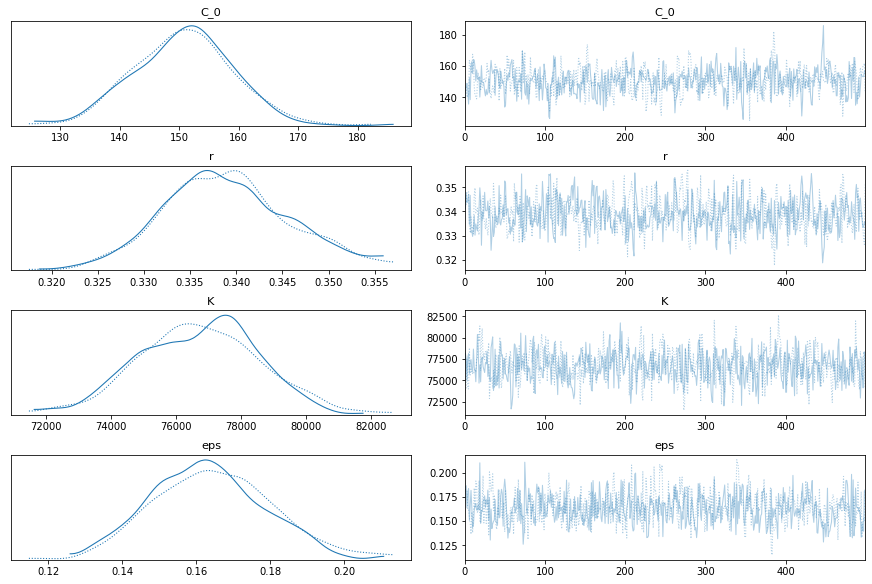

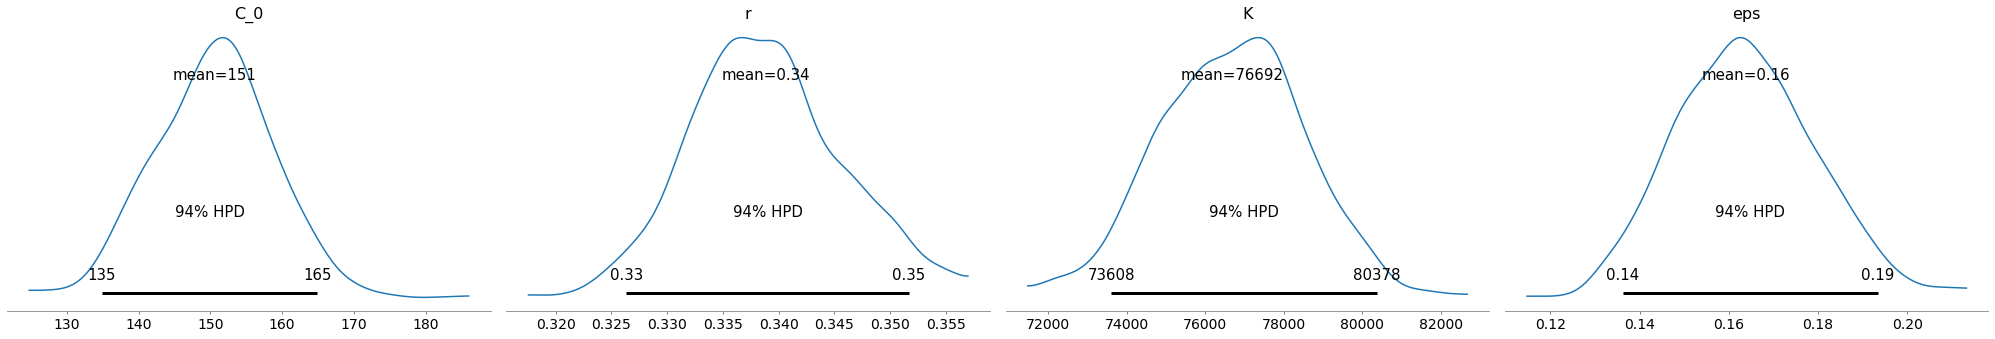

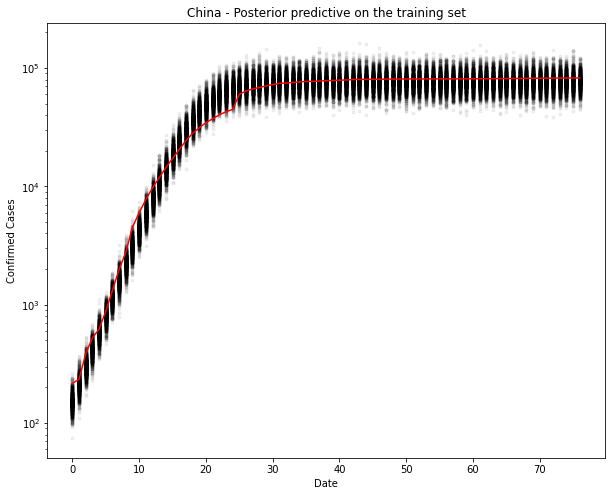

In [0]:
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

Yep, that looks ok. Let's test. I can't imagine it will be too wrong, since it's practically a straight line now.

100%|██████████| 1000/1000 [00:09<00:00, 101.39it/s]


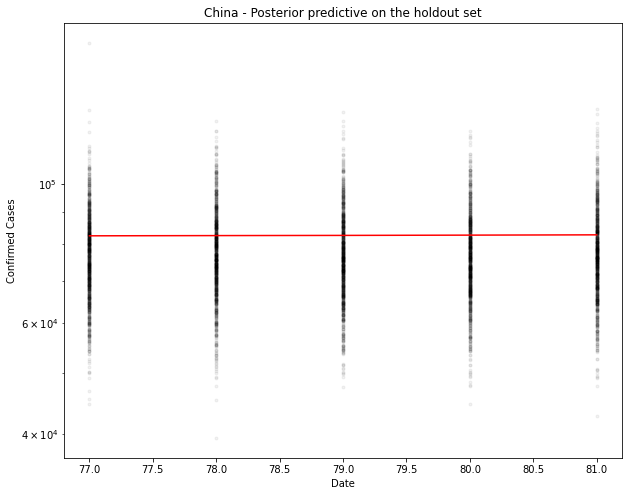

In [0]:
# New model with holdout data
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [0]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

[77296. 77720. 77172. 76707. 77911.]
1-day cumulative prediction error: -5279.0 cases (-6.4 %)
5-day cumulative prediction error: -4959.0 cases (-6.0 %)


In [0]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")

100%|██████████| 1000/1000 [00:09<00:00, 100.20it/s]



Based upon this model, tomorrow's number of cases will be 77409.0. In 5 days time there will be 77623.0 cases.


## UK Data

Let's try that again with UK data.



In [0]:
country = "United_Kingdom"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2018"] for key in df["country"].unique()}

In [0]:
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, K, r, C_0]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:03<00:00, 293.05it/s]
The acceptance probability does not match the target. It is 0.9090798356322464, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:09<00:00, 101.81it/s]


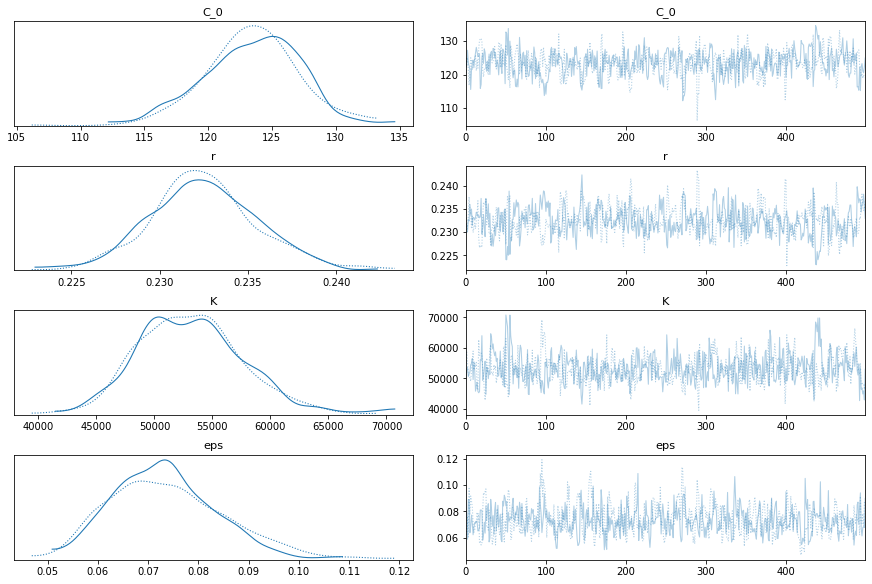

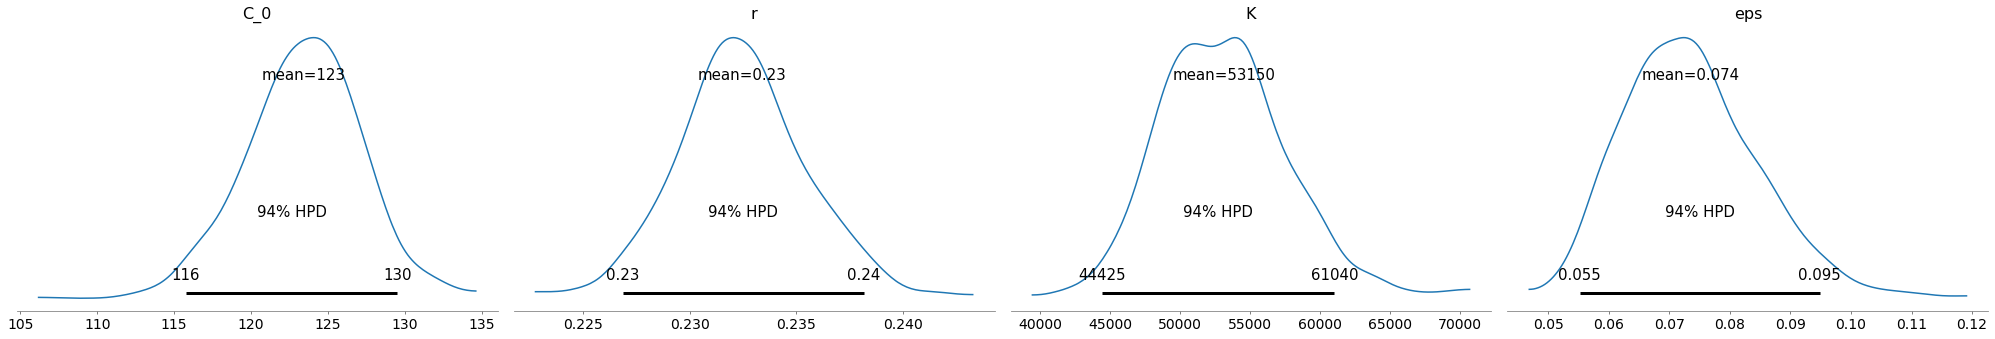

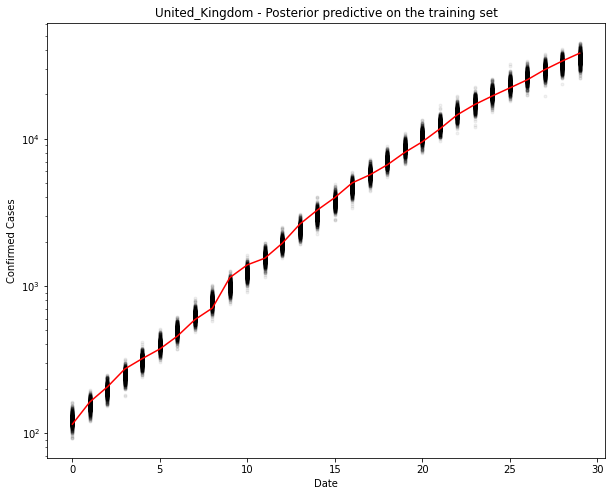

In [0]:
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

Yep, that looks ok. Let's test. I can't imagine it will be too wrong, since it's practically a straight line now.

100%|██████████| 1000/1000 [00:10<00:00, 95.50it/s]


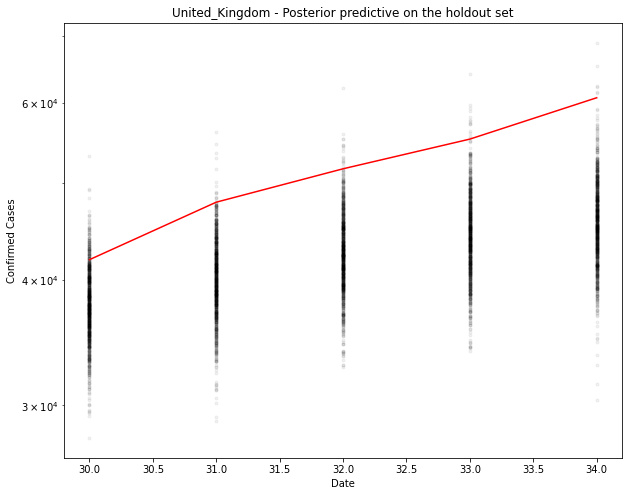

In [0]:
# New model with holdout data
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [0]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

[37849. 40187. 42660. 44396. 45723.]
1-day cumulative prediction error: -4054.0 cases (-9.7 %)
5-day cumulative prediction error: -15010.0 cases (-24.7 %)


In [0]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")

100%|██████████| 1000/1000 [00:09<00:00, 100.64it/s]



Based upon this model, tomorrow's number of cases will be 47325.0. In 5 days time there will be 50620.0 cases.


Slightly under for the UK. It seems to be tailing off a bit before the model predicts it should.